# elf1 perturbation simulation

## Library imports

In [25]:
import numpy as np
import pandas as pd
import torch
import scanpy as sc
import scvelo as scv
import scvi
import scipy

from regvelo import REGVELOVI
import cellrank as cr

import seaborn as sns
import matplotlib.pyplot as plt
import mplscience

from rgv_tools import DATA_DIR,FIG_DIR
from rgv_tools.benchmarking import (
    set_output,
)
from rgv_tools.perturbation import in_silico_block_simulation,abundance_test,get_list_name
from rgv_tools.perturbation import inferred_GRN,RegulationScanning

## Constants

In [3]:
DATASET = "zebrafish"

In [4]:
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)
    
SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

## Load dataset

In [30]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_run_regvelo.h5ad")

## elf1 perturbation simulation

In [6]:
model = DATA_DIR / DATASET / 'processed' / 'rgv_hard_model_all'
vae = REGVELOVI.load(model,adata)
set_output(adata, vae)

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(


100%|██████████| 697/697 [00:00<00:00, 1535.02cell/s]

Defaulting to `'gmres'` solver.


100%|██████████| 4/4 [00:00<00:00, 88.15/s]


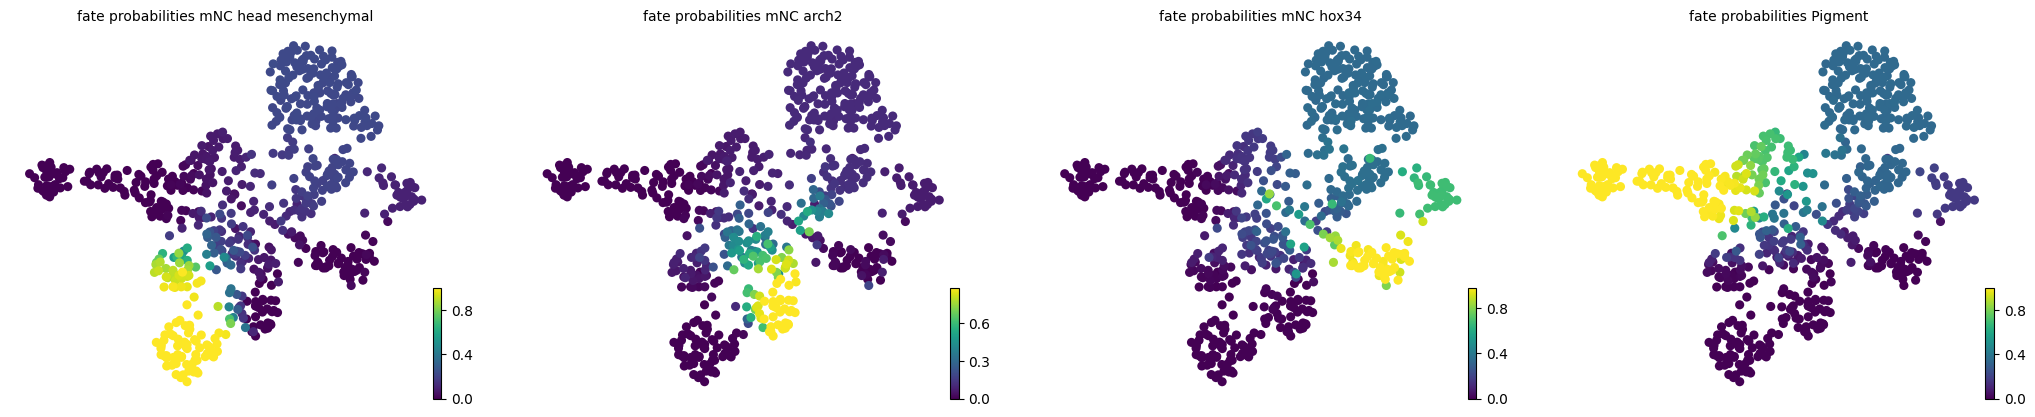

In [7]:
terminal_states = [
        "mNC_head_mesenchymal",
        "mNC_arch2",
        "mNC_hox34",
        "Pigment",
    ]
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
g_raw = cr.estimators.GPCCA(vk)
## evaluate the fate prob on original space
g_raw.compute_macrostates(n_states=7,cluster_key="cell_type")
g_raw.set_terminal_states(terminal_states)
g_raw.compute_fate_probabilities()
g_raw.plot_fate_probabilities(same_plot=False)

In [8]:
## Elf1
adata_target_perturb,reg_vae_perturb =  in_silico_block_simulation(model,adata,"elf1")

n_states = 7
vk = cr.kernels.VelocityKernel(adata_target_perturb)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_target_perturb).compute_transition_matrix()
g = cr.estimators.GPCCA(vk)
## evaluate the fate prob on original space
g.compute_macrostates(n_states=n_states,cluster_key="cell_type")
g.set_terminal_states(terminal_states)
g.compute_fate_probabilities()
## visualize coefficient
cond1_df = pd.DataFrame(adata_target_perturb.obsm["lineages_fwd"], columns=adata_target_perturb.obsm["lineages_fwd"].names.tolist())
cond2_df = pd.DataFrame(adata.obsm["lineages_fwd"], columns=adata.obsm["lineages_fwd"].names.tolist())

## abundance test
data = abundance_test(cond2_df, cond1_df)
data = pd.DataFrame({"Score": data.iloc[:,0].tolist(),
                 "p-value": data.iloc[:,1].tolist(),
                 "Terminal state": data.index.tolist(),
                 "TF":["elf1"]*(data.shape[0])})

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1461.60cell/s]


100%|██████████| 4/4 [00:00<00:00, 85.52/s]


In [9]:
final_df = data.copy()
final_df["Score"] = 0.5 - final_df["Score"]

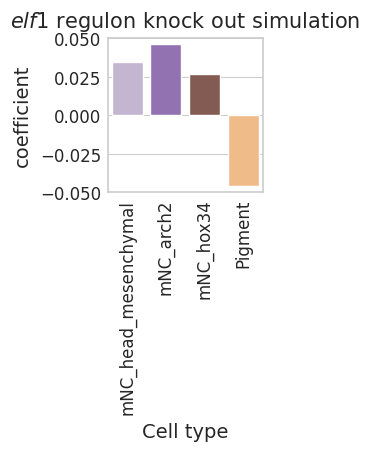

In [10]:
color_label = "cell_type"
df = pd.DataFrame(final_df["Score"])
df.columns = ["coefficient"]
df["Cell type"] = final_df["Terminal state"]
order = df["Cell type"].tolist()
    
palette = dict(zip(adata.obs[color_label].cat.categories, adata.uns[f"{color_label}_colors"]))
subset_palette = {name: color for name, color in palette.items() if name in final_df.loc[:,"Terminal state"].tolist()}

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(2,2))
    sns.barplot(
        data=df,
        y="coefficient",
        x="Cell type",
        palette=subset_palette,
        order=order,
        ax=ax,

    )
    ax.set(ylim=(-0.05,0.05))
    ax.tick_params(axis='x', rotation=90)
    plt.title("$\mathit{" + "elf1" + "}$ regulon knock out simulation")
    
    if SAVE_FIGURES:
        plt.savefig(
                FIG_DIR / DATASET / "elf1_perturbation_simulation.svg",
                format="svg",
                transparent=True,
                bbox_inches='tight'
            )
    # Show the plot
    plt.show()

## Compute GRN

In [14]:
GRN = inferred_GRN(vae,adata,label = "cell_type",group = "all",data_frame = True)

Computing global GRN...


### screening elf1 targets to explain why elf1 create depletion effect on pigment lineage

In [15]:
targets = GRN.loc[:,"elf1"]
targets = np.array(targets.index.tolist())[np.array(targets)!=0]

In [17]:
terminal_states = [
        "mNC_head_mesenchymal",
        "mNC_arch2",
        "mNC_hox34",
        "Pigment",
    ]

print("inferring perturbation...")
perturb_screening = RegulationScanning(model,adata,7,"cell_type",terminal_states,"elf1",targets,0)
coef = pd.DataFrame(np.array(perturb_screening['coefficient']))
coef.index = perturb_screening['target']
coef.columns = get_list_name(perturb_screening['coefficient'][0])

inferring perturbation...
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1484.83cell/s]


100%|██████████| 4/4 [00:00<00:00, 73.23/s]

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1480.96cell/s]


100%|██████████| 4/4 [00:00<00:00, 78.00/s]

Done ENSDARG00000024966
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1089.76cell/s]


100%|██████████| 4/4 [00:00<00:00, 75.49/s]

Done ENSDARG00000042329
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1552.48cell/s]


100%|██████████| 4/4 [00:00<00:00, 72.36/s]

Done alcama
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1612.13cell/s]


100%|██████████| 4/4 [00:00<00:00, 68.95/s]

Done aopep
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1480.17cell/s]


100%|██████████| 4/4 [00:00<00:00, 66.68/s]

Done apc
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1396.23cell/s]


100%|██████████| 4/4 [00:00<00:00, 66.27/s]

Done atp6v0ca
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1432.12cell/s]


100%|██████████| 4/4 [00:00<00:00, 63.17/s]

Done baz1b
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1408.84cell/s]


100%|██████████| 4/4 [00:00<00:00, 62.26/s]

Done calr3b
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1432.63cell/s]


100%|██████████| 4/4 [00:00<00:00, 59.35/s]

Done ccny
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1455.00cell/s]


100%|██████████| 4/4 [00:00<00:00, 61.22/s]

Done cdk1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1374.69cell/s]


100%|██████████| 4/4 [00:00<00:00, 58.31/s]

Done cdkn1ca
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1406.44cell/s]


100%|██████████| 4/4 [00:00<00:00, 56.23/s]

Done celf2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1303.17cell/s]


100%|██████████| 4/4 [00:00<00:00, 59.51/s]

Done cenpf
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1495.61cell/s]


100%|██████████| 4/4 [00:00<00:00, 56.02/s]

Done cpeb4b
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1482.01cell/s]


100%|██████████| 4/4 [00:00<00:00, 59.35/s]

Done cxxc5b
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1431.94cell/s]


100%|██████████| 4/4 [00:00<00:00, 60.19/s]

Done diaph2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1442.81cell/s]


100%|██████████| 4/4 [00:00<00:00, 56.23/s]

Done dlg1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1318.86cell/s]


100%|██████████| 4/4 [00:00<00:00, 53.19/s]


Done dnajb2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1425.85cell/s]


100%|██████████| 4/4 [00:00<00:00, 59.54/s]

Done dnmt1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1458.54cell/s]


100%|██████████| 4/4 [00:00<00:00, 58.28/s]

Done dusp5
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1371.14cell/s]


100%|██████████| 4/4 [00:00<00:00, 56.33/s]

Done ebf3a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1447.89cell/s]


100%|██████████| 4/4 [00:00<00:00, 53.55/s]

Done erbb3b
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1511.34cell/s]


100%|██████████| 4/4 [00:00<00:00, 53.09/s]

Done esco2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1404.99cell/s]


100%|██████████| 4/4 [00:00<00:00, 53.65/s]

Done ets1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1432.99cell/s]


100%|██████████| 4/4 [00:00<00:00, 53.36/s]

Done eva1ba
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1492.49cell/s]


100%|██████████| 4/4 [00:00<00:00, 51.11/s]

Done fam49a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1433.81cell/s]


100%|██████████| 4/4 [00:00<00:00, 50.97/s]

Done fhl3a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1371.96cell/s]


100%|██████████| 4/4 [00:00<00:00, 48.68/s]

Done fli1a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1337.07cell/s]


100%|██████████| 4/4 [00:00<00:00, 48.55/s]

Done foxo1a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1245.71cell/s]


100%|██████████| 4/4 [00:00<00:00, 46.09/s]


Done fzd3a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1354.17cell/s]


100%|██████████| 4/4 [00:00<00:00, 47.63/s]


Done glb1l
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1399.01cell/s]


100%|██████████| 4/4 [00:00<00:00, 45.24/s]


Done glulb
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1427.15cell/s]


100%|██████████| 4/4 [00:00<00:00, 43.86/s]


Done gpd2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1344.85cell/s]


100%|██████████| 4/4 [00:00<00:00, 43.24/s]


Done hat1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1336.36cell/s]


100%|██████████| 4/4 [00:00<00:00, 35.31/s]


Done hexb
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1354.28cell/s]


100%|██████████| 4/4 [00:00<00:00, 42.84/s]


Done hivep1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1190.28cell/s]


100%|██████████| 4/4 [00:00<00:00, 41.46/s]


Done hivep3b
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1350.85cell/s]


100%|██████████| 4/4 [00:00<00:00, 40.50/s]


Done hmgn2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1353.43cell/s]


100%|██████████| 4/4 [00:00<00:00, 41.02/s]


Done hnrnpabb
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1324.87cell/s]


100%|██████████| 4/4 [00:00<00:00, 39.80/s]


Done hpcal4
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1430.05cell/s]


100%|██████████| 4/4 [00:00<00:00, 40.29/s]


Done hsp70.2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1132.82cell/s]


100%|██████████| 4/4 [00:00<00:00, 39.38/s]


Done hspa5
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1276.95cell/s]


100%|██████████| 4/4 [00:00<00:00, 37.83/s]


Done hspb8
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1295.67cell/s]


100%|██████████| 4/4 [00:00<00:00, 38.87/s]


Done id2a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1369.66cell/s]


100%|██████████| 4/4 [00:00<00:00, 39.34/s]


Done ildr2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1340.68cell/s]


100%|██████████| 4/4 [00:00<00:00, 39.12/s]


Done inka1a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1263.43cell/s]


100%|██████████| 4/4 [00:00<00:00, 40.01/s]


Done itga3a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1448.47cell/s]


100%|██████████| 4/4 [00:00<00:00, 38.24/s]


Done itga8
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1214.46cell/s]


100%|██████████| 4/4 [00:00<00:00, 38.35/s]


Done ivns1abpa
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1361.34cell/s]


100%|██████████| 4/4 [00:00<00:00, 39.43/s]


Done klf6a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1458.05cell/s]


100%|██████████| 4/4 [00:00<00:00, 39.61/s]


Done kntc1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1120.40cell/s]


100%|██████████| 4/4 [00:00<00:00, 30.00/s]


Done mbnl2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1326.92cell/s]


100%|██████████| 4/4 [00:00<00:00, 39.42/s]


Done metrn
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1342.58cell/s]


100%|██████████| 4/4 [00:00<00:00, 39.51/s]


Done mibp
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1400.05cell/s]


100%|██████████| 4/4 [00:00<00:00, 38.07/s]


Done myo10l1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1376.49cell/s]


100%|██████████| 4/4 [00:00<00:00, 37.69/s]


Done nr6a1b
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1358.46cell/s]


100%|██████████| 4/4 [00:00<00:00, 38.54/s]


Done pcdh2g28
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1350.24cell/s]


100%|██████████| 4/4 [00:00<00:00, 39.39/s]


Done pdlim4
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1435.58cell/s]


100%|██████████| 4/4 [00:00<00:00, 39.36/s]


Done plpp3
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1420.15cell/s]


100%|██████████| 4/4 [00:00<00:00, 39.05/s]


Done pmp22a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1305.77cell/s]


100%|██████████| 4/4 [00:00<00:00, 39.43/s]


Done ppt1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1365.45cell/s]


100%|██████████| 4/4 [00:00<00:00, 37.39/s]


Done prdm1a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1365.36cell/s]


100%|██████████| 4/4 [00:00<00:00, 37.92/s]


Done prkceb
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1283.73cell/s]


100%|██████████| 4/4 [00:00<00:00, 39.39/s]


Done prkcsh
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1236.27cell/s]


100%|██████████| 4/4 [00:00<00:00, 39.13/s]


Done pttg1ipb
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1328.00cell/s]


100%|██████████| 4/4 [00:00<00:00, 38.44/s]


Done rabl6b
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1268.96cell/s]


100%|██████████| 4/4 [00:00<00:00, 37.99/s]


Done ralgps2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1327.65cell/s]


100%|██████████| 4/4 [00:00<00:00, 37.68/s]


Done rgl1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1281.52cell/s]


100%|██████████| 4/4 [00:00<00:00, 33.91/s]


Done rhbdf1a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1276.25cell/s]


100%|██████████| 4/4 [00:00<00:00, 39.07/s]


Done rhoca
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1447.48cell/s]


100%|██████████| 4/4 [00:00<00:00, 38.42/s]


Done rxraa
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1327.69cell/s]


100%|██████████| 4/4 [00:00<00:00, 38.53/s]


Done sash1b
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1163.72cell/s]


100%|██████████| 4/4 [00:00<00:00, 36.80/s]


Done sema3d
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1219.62cell/s]


100%|██████████| 4/4 [00:00<00:00, 38.09/s]


Done sema4ba
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1301.61cell/s]


100%|██████████| 4/4 [00:00<00:00, 38.52/s]


Done sept12
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1330.36cell/s]


100%|██████████| 4/4 [00:00<00:00, 38.28/s]


Done sept9a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1403.10cell/s]


100%|██████████| 4/4 [00:00<00:00, 38.41/s]


Done serinc5
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1399.53cell/s]


100%|██████████| 4/4 [00:00<00:00, 38.42/s]


Done shroom4
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1360.86cell/s]


100%|██████████| 4/4 [00:00<00:00, 36.64/s]


Done si:ch211-199g17.2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1302.10cell/s]


100%|██████████| 4/4 [00:00<00:00, 37.70/s]


Done si:ch211-222l21.1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1391.11cell/s]


100%|██████████| 4/4 [00:00<00:00, 36.62/s]


Done si:ch73-335l21.1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1338.89cell/s]


100%|██████████| 4/4 [00:00<00:00, 38.39/s]


Done si:dkey-17m8.1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1455.35cell/s]


100%|██████████| 4/4 [00:00<00:00, 39.28/s]


Done sipa1l2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1324.65cell/s]


100%|██████████| 4/4 [00:00<00:00, 38.54/s]


Done slbp
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1366.13cell/s]


100%|██████████| 4/4 [00:00<00:00, 37.41/s]


Done slc12a9
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1309.81cell/s]


100%|██████████| 4/4 [00:00<00:00, 37.67/s]


Done sox6
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1335.47cell/s]


100%|██████████| 4/4 [00:00<00:00, 37.03/s]


Done src
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1401.89cell/s]


100%|██████████| 4/4 [00:00<00:00, 36.74/s]


Done stat3
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1338.00cell/s]


100%|██████████| 4/4 [00:00<00:00, 39.03/s]


Done tcf12
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1341.39cell/s]


100%|██████████| 4/4 [00:00<00:00, 37.84/s]


Done tes
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1429.23cell/s]


100%|██████████| 4/4 [00:00<00:00, 38.41/s]


Done tle3b
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1396.34cell/s]


100%|██████████| 4/4 [00:00<00:00, 38.45/s]


Done tuba8l4
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1324.87cell/s]


100%|██████████| 4/4 [00:00<00:00, 37.73/s]


Done vash2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1304.79cell/s]


100%|██████████| 4/4 [00:00<00:00, 36.78/s]


Done vav2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1287.28cell/s]


100%|██████████| 4/4 [00:00<00:00, 38.13/s]


Done zgc:154093
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_hard_model_all/model.pt   
         already downloaded                                                                                        


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1324.32cell/s]


100%|██████████| 4/4 [00:00<00:00, 37.50/s]


Done zgc:165573


In [19]:
coef.sort_values("Pigment",ascending=False).iloc[:15,]

,mNC_head_mesenchymal,mNC_arch2,mNC_hox34,Pigment
fli1a,0.489231,0.473997,0.510762,0.519782
fzd3a,0.497162,0.488964,0.494987,0.514482
rxraa,0.502704,0.502113,0.488569,0.513772
esco2,0.496203,0.486210,0.497570,0.513539
baz1b,0.497543,0.494172,0.494542,0.513082
si:ch73-335l21.1,0.497090,0.487735,0.497465,0.511703
hat1,0.497951,0.487904,0.496940,0.511236
metrn,0.498914,0.483554,0.498780,0.509993
dnmt1,0.499206,0.487224,0.497064,0.509616
ppt1,0.498186,0.494913,0.497309,0.508202


In [20]:
Pigment = coef.sort_values(by='Pigment', ascending=False)[:15]["Pigment"]

/tmp/ipykernel_2646956/540425202.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x='Score', y='Gene', palette='purple', s=200, legend=False)


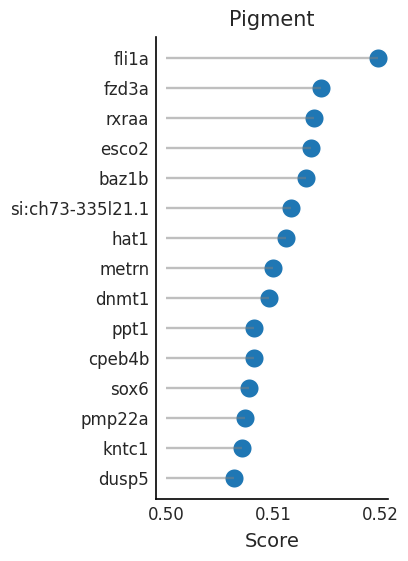

In [22]:
df = pd.DataFrame({'Gene': Pigment.index.tolist(), 'Score': np.array(Pigment)})

# Sort DataFrame by -log10(p-value) for ordered plotting
df = df.sort_values(by='Score', ascending=False)

# Highlight specific genes
# Set up the plot
with mplscience.style_context():
    sns.set_style(style="white")
    fig, ax = plt.subplots(figsize=(3,6))
    sns.scatterplot(data=df, x='Score', y='Gene', palette='purple', s=200, legend=False)

    for _, row in df.iterrows():
        plt.hlines(row['Gene'], xmin=0.5, xmax=row['Score'], colors='grey', linestyles='-', alpha=0.5)

    # Customize plot appearance
    plt.xlabel('Score')
    plt.ylabel('')
    plt.title('Pigment')

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_color('black')
    plt.gca().spines['bottom'].set_color('black')
    # Show plot
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / 'elf1_driver.svg',
            format='svg',
            transparent=True,
            bbox_inches='tight'
        )
    plt.show()

## Calculate activity of positive regulated genes

In [23]:
elf1_g = np.array(GRN.index.tolist())[np.array(GRN.loc[:,"elf1"])!=0]
fli1a_g = np.array(GRN.index.tolist())[np.array(GRN.loc[:,"fli1a"])!=0]

In [26]:
score = adata[:,elf1_g].layers["Ms"].mean(1) - adata[:,fli1a_g].layers["Ms"].mean(1)
score = scipy.stats.zscore(np.array(score))

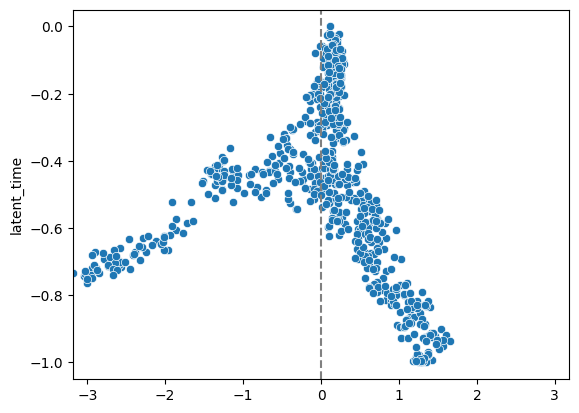

In [33]:
sns.scatterplot(x = score,y = -adata.obs["latent_time"])
max_abs_x = max(abs(np.min(score)), abs(np.max(score)))
plt.xlim(-max_abs_x, max_abs_x)

# Display the plot
plt.axvline(0, color='grey', linestyle='--')  # Optional: add a vertical line at x=0 for clarity

## Use it as new coordinate system and plot the figure

In [34]:
adata.obsm["X_togglesiwtch"] = np.column_stack((score,-adata.obs["latent_time"]))

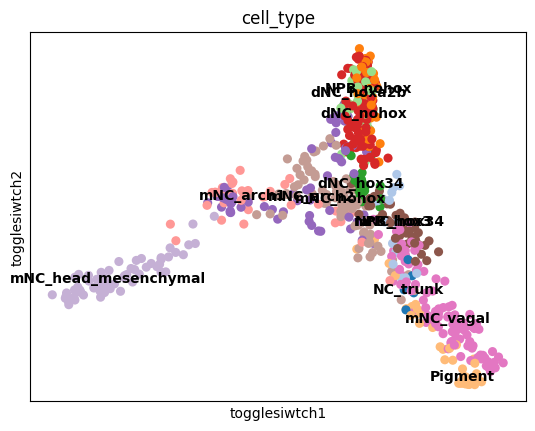

In [35]:
sc.pl.embedding(adata, basis = "togglesiwtch", color='cell_type',palette = sc.pl.palettes.vega_20,legend_loc = "on data")

In [36]:
adata.obs["ToggleState"] = [
    i if i in ["mNC_head_mesenchymal", "Pigment"] else np.nan 
    for i in adata.obs["macrostates"]
]
adata.obs["ToggleState"] = adata.obs["ToggleState"].astype("category")

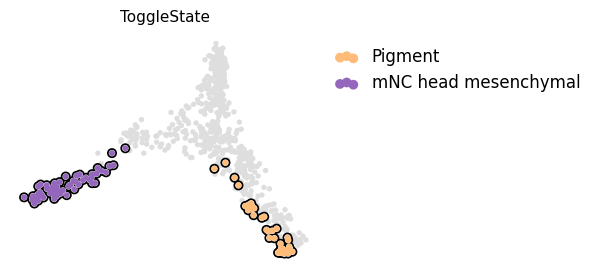

In [37]:
which = "ToggleState"
#adata.obs[which] = adata.obs["cell_type2"].copy()

state_names = adata.obs[which].cat.categories.tolist()
adata.obs[which] = adata.obs[which].astype(str).astype("category").cat.reorder_categories(["nan"] + state_names)

if which == "ToggleState":
    adata.uns[f"{which}_colors"] = ["#dedede"] + list(subset_palette.values())
else:
    adata.uns[f"{which}_colors"] = ["#dedede"] + list(subset_palette.values())
state_names = adata.obs[which].cat.categories.tolist()[1:]


with mplscience.style_context():
    fig, ax = plt.subplots(figsize = (4,3))
    scv.pl.scatter(adata, 
                   basis = "togglesiwtch", 
                   c=which,
                   add_outline=state_names,
                   ax=ax,
                   size = 60)
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / 'fli1a_elf1.svg',
            format = 'svg',
            transparent = True,
            bbox_inches = 'tight'
        )

In [38]:
if SAVE_DATA:
    adata.write_h5ad(DATA_DIR / DATASET / "results" / "elf1_screening.csv")